In [208]:
from GoogleNews import GoogleNews
from newspaper import Article
import pandas as pd
import numpy as np
import time

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sqlite3 import Error
from sklearn.ensemble import RandomForestClassifier
import sqlite3
import pickle
import re
import math

import warnings
warnings.filterwarnings("ignore")

## Description

To find keywords to identify relevant articles, I try to use word tokens to build a classification model and predict each article's topic.

## 1. Scraping Google News

Here I use categories that Fidelity provided as keywords to search on GoogleNews, and download 60 news through GoogleNews API and the newspaper package.

More information please see this link:
https://medium.com/analytics-vidhya/googlenews-api-live-news-from-google-news-using-python-b50272f0a8f0

In [204]:
topics = ['compliance', 'cybersecurity', 'surveillance', 'market structure', 
'Regulation', 'short sales', 'funds', 'Securities', 'investment']

In [229]:
googlenews = GoogleNews(start='01/01/2020',end='10/15/2020')

# Everytime we search for a new keyword, 
# it will save the first two pages result in googlenews.result()
for keyword in topics:
    googlenews.search(keyword)
    
    # Require it to return page 3,4,5,6 as well (each page has 10 news)
    for i in range(4):
        googlenews.getpage(i+2) 
    
    result = googlenews.result()
    
    
results_df = pd.DataFrame(result)
# Remove duplicated news
results_df = results_df.loc[~results_df.duplicated()]
results_df.head()

,title,media,date,desc,link,img
0,Former Goldman Sachs exec tabbed as USOPC comp...,ESPN,"Jul 21, 2020",-- The U.S. Olympic and Paralympic Committee h...,https://www.espn.com/olympics/story/_/id/29509...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
1,OPEC+ data reveals extent of oil quota non-com...,,"Aug 20, 2020","Full compliance with the deal, including the c...",https://www.spglobal.com/platts/en/market-insi...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
2,"Nevada OSHA issues 11 workplace citations, 9 f...",FOX5 Las Vegas,"Aug 17, 2020",CITY COMPLIANCE. Cities with compliance rates ...,https://www.fox5vegas.com/coronavirus/nevada-o...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
3,Australia's Westpac reveals findings from comp...,Reuters,"Jun 3, 2020",Unclear accountabilities as well as a lack of ...,https://www.reuters.com/article/us-westpac-reg...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."
4,Hong Kong financial firms step up compliance h...,Reuters,1 month ago,HONG KONG (Reuters) - Financial firms in Hong ...,https://www.reuters.com/article/hongkong-secur...,"data:image/gif;base64,R0lGODlhAQABAIAAAP//////..."


In [239]:
# Download titles and summaries for all news

all_news = []

for i, row in results_df.iterrows():
    kw_id = math.floor(i/60)

    article = Article(row['link'])
    
    try:
        article.download()
        article.parse()
        article.nlp()

        if article.title != 'StackPath':
            news_list = [topics[kw_id], row['date'], row['media'], 
                         article.title, article.summary]
            all_news.append(news_list)

    # if an article cannot be downloaded without authorization, then skip it
    except: continue 

columns = ['keyword', 'date', 'media', 'title', 'summary']
df = pd.DataFrame(all_news, columns=columns)
df.head()

,keyword,date,media,title,summary
0,compliance,"Jul 21, 2020",ESPN,Former Goldman Sachs exec tabbed as USOPC comp...,"COLORADO SPRINGS, Colo. -- The U.S. Olympic an..."
1,compliance,"Aug 20, 2020",,OPEC+ data reveals extent of oil quota non-com...,The OPEC+ alliance in May implemented the larg...
2,compliance,"Aug 17, 2020",FOX5 Las Vegas,"Nevada OSHA issues 11 workplace citations, 9 f...",Close Get email notifications on {{subject}} d...
3,compliance,"Jun 3, 2020",Reuters,Australia's Westpac reveals findings from comp...,FILE PHOTO: A pedestrian looks at his phone as...
4,compliance,1 month ago,Reuters,Hong Kong financial firms step up compliance h...,HONG KONG (Reuters) - Financial firms in Hong ...


In [240]:
df['keyword'].value_counts()

surveillance        60
market structure    60
compliance          59
cybersecurity       58
short sales         58
funds               57
Regulation          56
Securities          26
Name: keyword, dtype: int64

## 2. Text Preprocressing

Reference: https://towardsdatascience.com/multi-class-text-classification-with-sklearn-and-nltk-in-python-a-software-engineering-use-case-779d4a28ba5

In [241]:
# Preprocessing
stemmer = PorterStemmer()
words = stopwords.words("english")
processing = lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower()

df['cleaned'] = (df['title'] + ' ' + df['summary']).apply(processing)
df['cleaned'].head()

0    former goldman sach exec tab usopc complianc o...
1    opec data reveal extent oil quota non complian...
2    nevada osha issu workplac citat covid non comp...
3    australia westpac reveal find complianc review...
4    hong kong financi firm step complianc hire ami...
Name: cleaned, dtype: object

## 3. Training Model (Use Random Forest as an Example)

Reference:
https://towardsdatascience.com/multi-class-text-classification-with-sklearn-and-nltk-in-python-a-software-engineering-use-case-779d4a28ba5

In [242]:
X = df['cleaned']
Y = df['keyword']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

In [243]:
vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", 
                             sublinear_tf=True, norm='l2', 
                             ngram_range=(1, 2))

pipeline = Pipeline([('vect', vectorizer), # Transform a document into a vector
                     ('chi',  SelectKBest(chi2, k=300)), # Use chi-test to select 300 features
                     ('clf', RandomForestClassifier())]) # Use Random Forest to identify topic 

model = pipeline.fit(X_train, y_train)

# Save the model to a pickle file
with open('RandomForest.pickle', 'wb') as f:
    pickle.dump(model, f)

## 4. Model Evaluation

### Classification Report

In [244]:
ytest = np.array(y_test)
print(classification_report(ytest, model.predict(X_test)))

                  precision    recall  f1-score   support

      Regulation       1.00      0.94      0.97        17
      Securities       0.33      0.20      0.25         5
      compliance       0.93      0.82      0.87        17
   cybersecurity       0.73      0.67      0.70        12
           funds       0.53      0.60      0.56        15
market structure       0.40      0.43      0.41        14
     short sales       0.69      0.73      0.71        15
    surveillance       0.44      0.50      0.47        14

        accuracy                           0.66       109
       macro avg       0.63      0.61      0.62       109
    weighted avg       0.67      0.66      0.66       109



## Feature Importance

The link about chi-test feature selection:
https://towardsdatascience.com/chi-square-test-for-feature-selection-in-machine-learning-206b1f0b8223

In [248]:
all_features = np.array(model.steps[0][1].get_feature_names())
mask = model.steps[1][1].get_support()
new_features = all_features[mask]
print('Select {1} features from {0} features by chi-test'.format(len(all_features), len(new_features)))

Select 300 features from 1822 features by chi-test


<AxesSubplot:>

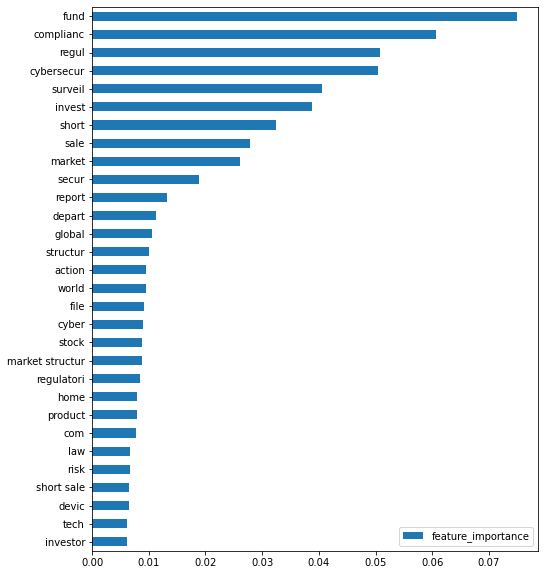

In [249]:
feature_importance = pd.DataFrame(model.steps[2][1].feature_importances_, index=new_features, columns=['feature_importance'])
feature_importance.sort_values('feature_importance').tail(30).plot.barh(figsize=[8,10])

## 5. Apply the model to other unlabeld sources

In [250]:
forbes = "SEC Threatens Fines, Suspensions For Covid-19 Protocol Violations. Southeastern Conference Commissioner Greg Sankey sent a memo to the conference's football coaches and athletic directors last Wednesday, following the opening weekend of the SEC season, reminding coaches and players to wear masks on the sidelines, and followed up with another memo this week warning of possible fines and suspensions if protocols are violated."
nlr ="CCO Barred for Altering Reports to Mislead SEC Staff. Recently, the U.S. Securities and Exchange Commission (the “SEC”) charged a dually registered firm and its Chief Compliance Officer (“CCO”) with multiple violations of the Investment Advisers Act of 1940 (“Advisers Act”). The charges included allegations against the CCO that she altered documents in an attempt to mislead SEC examination staff and failures to comply with enhanced policies and procedures adopted as a result of a prior examination by FINRA. The SEC charged the firm with willfully violating Section 206(4) of the Advisers Act and Rule 206(4)-7 thereunder, which require, in part, that registered investment advisors “[a]dopt and implement written policies and procedures reasonably designed to prevent violation” of the Advisers Act and its rules. The CCO was charged with willfully aiding and abetting the firm’s violations. The firm and the CCO were fined $1.7 million and $45,000, respectively, and the CCO was barred from the industry."
fcpa = "Brazil holding company agrees to pay $285 million to settle FCPA violations. São Paulo-based conglomerate J&F Investimentos pleaded guilty Wednesday to conspiracy to violate the anti-bribery provisions of the Foreign Corrupt Practices Act for a scheme to bribe officials in Brazil."

new_data = pd.DataFrame([forbes, nlr, fcpa], columns=['text'])
new_data['cleaned'] = new_data['text'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

In [251]:
# Predict topics for three articles
new_X = new_data['cleaned']
print(model.predict(new_X))

['funds' 'compliance' 'funds']


In [252]:
# Return probabilities for differnt topics
prob_for_different_topics = pd.DataFrame(model.predict_proba(new_X), columns=model.steps[2][1].classes_, index=['forbes', 'nlr', 'fcpa'])
prob_for_different_topics

,Regulation,Securities,compliance,cybersecurity,funds,market structure,short sales,surveillance
forbes,0.00,0.00,0.08,0.02,0.420167,0.02,0.04,0.419833
nlr,0.00,0.13,0.50,0.01,0.240000,0.05,0.03,0.040000
fcpa,0.02,0.01,0.02,0.05,0.383333,0.03,0.15,0.336667


#### SEC articles

In [253]:
sec = pd.read_csv('SEC_articles.csv')
sec['cleaned'] = (sec['title'] + ' ' + sec['abstract']).apply(processing)
sec['category_pred'] = model.predict(sec['cleaned'])
sec[['title', 'category_pred']]

,title,category_pred
0,SEC and CFTC to Hold a Joint Open Meeting on O...,funds
1,SEC Charges Andeavor for Inadequate Controls A...,funds
2,Board Member James G. Kaiser to Retire From th...,funds
3,SEC Appoints PCAOB Chief Auditor Megan Zietsma...,funds
4,"SEC Awards $800,000 to Whistleblower",funds
5,SEC Charges Brazilian Meat Producers With FCPA...,funds
6,Tamara Brightwell Named Deputy Director of Div...,funds
7,Jessica Kane Named Director of Division of Cor...,funds
8,"SEC Charges Seismic Data Company, Former Execu...",funds
9,SEC Names Nichola L. Timmons Chief of New Offi...,funds
